# Load data, train model

In [1]:
import shap
import pickle
import lightgbm as lgb
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

/homes/gws/mingyulu/miniconda3/envs/torch_gpu/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load data
X, y = shap.datasets.adult()
X_display, y_display = shap.datasets.adult(display=True)
num_features = X.shape[1]

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)
d_train = lgb.Dataset(X_train, label=y_train)
d_tx_train = lgb.Dataset(X_train.loc[:, ~X_train.columns.isin(["Sex"])], label=X_train["Sex"])

d_tx_test = lgb.Dataset(X_test.loc[:, ~X_test.columns.isin(["Sex"])], label=X_test["Sex"])
d_test = lgb.Dataset(X_test, label=y_test)

In [4]:
X_test.values[:512]

array([[ 39.,   4.,  10., ..., 625.,  40.,  39.],
       [ 48.,   1.,  13., ...,   0.,  58.,  39.],
       [ 22.,   4.,  10., ...,   0.,  35.,  39.],
       ...,
       [ 19.,   4.,   9., ...,   0.,  40.,  39.],
       [ 73.,   5.,   6., ...,   0.,  40.,   2.],
       [ 18.,   4.,  10., ...,   0.,  16.,  39.]])

In [14]:
# Train model
params = {
    "max_bin": 512,
    "learning_rate": 0.05,
    "boosting_type": "gbdt",
    "objective": "binary",
    "metric": "binary_logloss",
    "num_leaves": 10,
    "verbose": -1,
    "min_data": 100,
    "boost_from_average": True
}

model = lgb.train(params, d_train, 10000, valid_sets=[d_test], early_stopping_rounds=50, verbose_eval=1000)

tx_model = lgb.train(params, d_tx_train, 10000, valid_sets=[d_tx_test], early_stopping_rounds=50, verbose_eval=1000)

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[644]	valid_0's binary_logloss: 0.278029
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[317]	valid_0's binary_logloss: 0.284236


# SHAP cooperative game

In [15]:
from shapreg import removal, games, shapley, shapley_sampling

In [16]:
# Make model callable
model_lam = lambda x: model.predict(x)
tx_model_lam = lambda x: tx_model.predict(x)
# Model extension
marginal_extension = removal.MarginalExtension(X_test.values[:512], model_lam)

## Interventional 
#interventional_extension = removal.InterventionalExtension(X_test.values[:512], model_lam,tx_model_lam ,0.2)

In [17]:
# Set up game (single prediction)
instance = X.values[0]
print(instance)
game = games.PredictionGame(marginal_extension, instance)

[3.900e+01 7.000e+00 1.300e+01 4.000e+00 1.000e+00 0.000e+00 4.000e+00
 1.000e+00 2.174e+03 0.000e+00 4.000e+01 3.900e+01]


In [11]:
# Run estimator
explanation = shapley.ShapleyRegression(game, batch_size=32)
explanation

100%|███████████████████████████████████████████████| 1/1 [00:03<00:00,  3.86s/it]


Shapley Values(
  (Mean): [ 0.00 -0.01  0.03 -0.04 -0.01 -0.06  0.00  0.01 -0.13 -0.00 -0.01 -0.00]
  (Std):  [0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00]
)

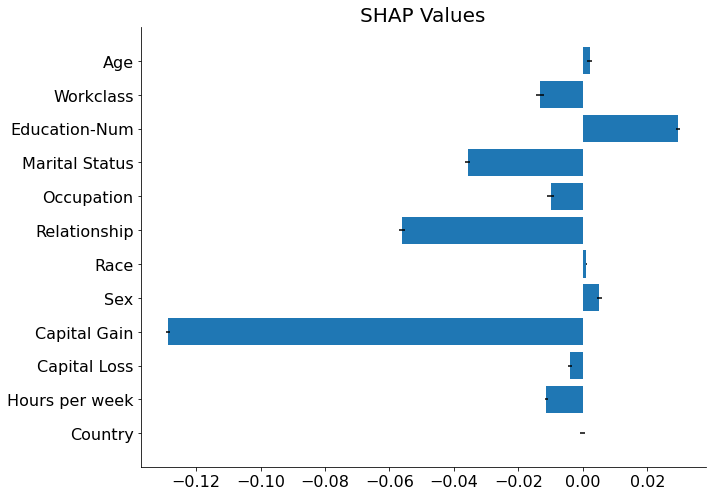

In [10]:
# Plot with 95% confidence intervals
feature_names = X.columns.tolist()    
explanation.plot(feature_names, title='SHAP Values', sort_features=False)

# LossSHAP cooperative game

In [9]:
from shapreg.utils import crossentropyloss

In [10]:
# Set up game (single prediction)
instance = X.values[1]
label = y[1].astype(int)
game = games.PredictionLossGame(marginal_extension, instance, label, crossentropyloss)

In [11]:
# Run estimator
explanation = shapley.ShapleyRegression(game, batch_size=32)

  0%|          | 0/1 [00:00<?, ?it/s]

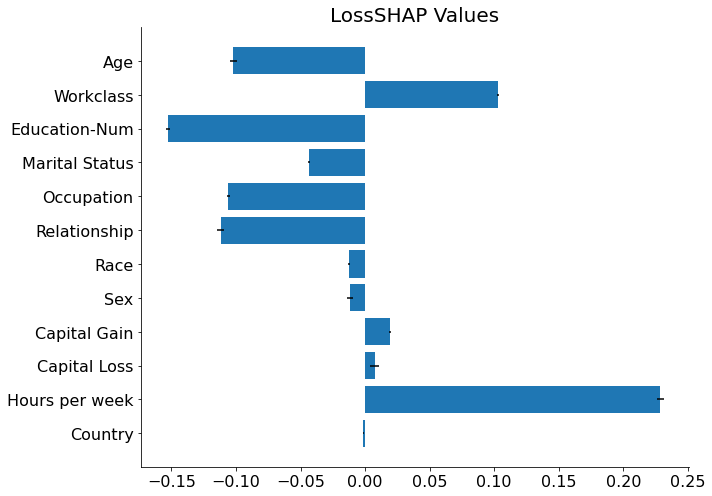

In [12]:
# Plot with 95% confidence intervals
explanation.plot(feature_names, title='LossSHAP Values', sort_features=False)